# Objective 
Incrementally improve a simple ticket routing app.
Steps:
- Simple prompting
- K-shot with RAG inyeyection (few shot prompt)
- RAG + Chain of thought

# Ticket routing problem

Essentially, it is a **classification problem**. Before going, **ask yourself the following questions**:

1. Why use an LLM?
    - limited labeled training data
    - classification categories evolve
    - unstructured inputs
    - handle edge cases
    - multi-lingual support

2. How is the current solution perfoming? Understand it.
    - SLA (service level agreement) criteria?
    - automated rules or workflows?
    - how are edghe cases handled?
    - how does the team prioritize the tickets?

3. Define user intent categories

4. Establish success criteria

5. Choose the right model

# Stage 1: Basic classification

### Load libraries

In [1]:
from dotenv import load_dotenv
import os
import anthropic

load_dotenv()
client = anthropic.Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))

### Build a prompt

Set the default model

In [2]:
DEFAULT_MODEL="claude-3-haiku-20240307"

The prompt...

In [3]:
def create_prompt(ticket_contents):
    # Define the prompt for the classification task
    
    classification_prompt = f"""You will be acting as a customer support ticket classification system. Your task is to analyze customer support requests and output the appropriate classification intent for each request, along with your reasoning. 

        Here is the customer support request you need to classify:

        <request>{ticket_contents}</request>

        Please carefully analyze the above request to determine the customer's core intent and needs. Consider what the customer is asking for has concerns about.

        First, write out your reasoning and analysis of how to classify this request inside <reasoning> tags.

        Then, output the appropriate classification label for the request inside a <intent> tag. The valid intents are:
        <intents>
        <intent>Support, Feedback, Complaint</intent>
        <intent>Order Tracking</intent>
        <intent>Refund/Exchange</intent>
        </intents>

        A request may have ONLY ONE applicable intent. Only include the intent that is most applicable to the request.

        As an example, consider the following request:
        <request>Hello! I had high-speed fiber internet installed on Saturday and my installer, Kevin, was absolutely fantastic! Where can I send my positive review? Thanks for your help!</request>

        Here is an example of how your output should be formatted (for the above example request):
        <reasoning>The user seeks information in order to leave positive feedback.</reasoning>
        <intent>Support, Feedback, Complaint</intent>

        Here are a few more examples:
        <examples>
        <example 2>
        Example 2 Input:
        <request>I wanted to write and personally thank you for the compassion you showed towards my family during my father's funeral this past weekend. Your staff was so considerate and helpful throughout this whole process; it really took a load off our shoulders. The visitation brochures were beautiful. We'll never forget the kindness you showed us and we are so appreciative of how smoothly the proceedings went. Thank you, again, Amarantha Hill on behalf of the Hill Family.</request>

        Example 2 Output:
        <reasoning>User leaves a positive review of their experience.</reasoning>
        <intent>Support, Feedback, Complaint</intent>
        </example 2>
        <example 3>

        ...

        </example 8>
        <example 9>
        Example 9 Input:
        <request>Your website keeps sending ad-popups that block the entire screen. It took me twenty minutes just to finally find the phone number to call and complain. How can I possibly access my account information with all of these popups? Can you access my account for me, since your website is broken? I need to know what the address is on file.</request>

        Example 9 Output:
        <reasoning>The user requests help accessing their web account information.</reasoning>
        <intent>Support, Feedback, Complaint</intent>
        </example 9>

        Remember to always include your classification reasoning before your actual intent output. The reasoning should be enclosed in <reasoning> tags and the intent in <intent> tags. Return only the reasoning and the intent.
        """
        
    return classification_prompt

In [4]:
print(create_prompt("REQUEST"))

You will be acting as a customer support ticket classification system. Your task is to analyze customer support requests and output the appropriate classification intent for each request, along with your reasoning. 

        Here is the customer support request you need to classify:

        <request>REQUEST</request>

        Please carefully analyze the above request to determine the customer's core intent and needs. Consider what the customer is asking for has concerns about.

        First, write out your reasoning and analysis of how to classify this request inside <reasoning> tags.

        Then, output the appropriate classification label for the request inside a <intent> tag. The valid intents are:
        <intents>
        <intent>Support, Feedback, Complaint</intent>
        <intent>Order Tracking</intent>
        <intent>Refund/Exchange</intent>
        </intents>

        A request may have ONLY ONE applicable intent. Only include the intent that is most applicable to the r

Note the following:

- **Few-shot prompting** is used
- Use of **XML tags** helps to retreive the answer easily, and builds a better rpompt structure for the LLM to understand



### Deploy the prompt and evaluate

Use:

- Accuracy
- Cost per classification

In [5]:
import re

def classify_support_request(request, actual_intent):
    
    # Define the prompt for the classification task
    classification_prompt = create_prompt(request)
    
    # Send the prompt to the API to classify the support request.
    message = client.messages.create(
        model=DEFAULT_MODEL,
        max_tokens=500,
        temperature=0,
        messages=[{
            "role": "user", 
            "content": classification_prompt
        }],
        stream=False,
    )
    
    usage = message.usage  # Get the usage statistics for the API call for how many input and output tokens were used.
    reasoning_and_intent = message.content[0].text

    # Use Python's regular expressions library to extract `reasoning`.
    reasoning_match = re.search(
        r"<reasoning>(.*?)</reasoning>", reasoning_and_intent, re.DOTALL
    )
    reasoning = reasoning_match.group(1).strip() if reasoning_match else ""

    # Similarly, also extract the `intent`.
    intent_match = re.search(r"<intent>(.*?)</intent>", reasoning_and_intent, re.DOTALL)
    intent = intent_match.group(1).strip() if intent_match else ""

    # Check if the model's prediction is correct.
    correct = actual_intent.strip() == intent.strip()

    # Return the reasoning, intent, correct, and usage.
    return reasoning, intent, correct, usage

### Test it out

In [6]:
user_req = "I need my money back, the product did not performed as promised."
user_intent = "Support, Feedback, Complaint"

classify_support_request(user_req, user_intent)

('The customer is requesting a refund for a product that did not perform as promised. The customer is expressing dissatisfaction with the product and is seeking a resolution in the form of a refund.',
 'Refund/Exchange',
 False,
 Usage(cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=715, output_tokens=60))

In [7]:
user_req = "I dont know where my package is at. When will it arrive?"
user_intent = "Support, Feedback, Complaint"

classify_support_request(user_req, user_intent)

("The customer is inquiring about the status and delivery of their package, indicating that they do not know where it is currently located. This suggests that the customer's core intent is to track the order and determine when it will arrive.",
 'Order Tracking',
 False,
 Usage(cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=716, output_tokens=64))

# Stage 2: Improve the model

### Load/get data

Lets load  train/test data to improve and evaluate the model.

**Note**: cap examples to 50 to avoid API rate limits

In [8]:
import pandas as pd

data = {
    'train': [],
    'test': [],
    'test_2': []
}

# Helper function to convert a DataFrame to a list of dictionaries
def dataframe_to_dict_list(df):
    return df.apply(lambda x: {'text': x['text'], 'label': x['label']}, axis=1).tolist()


# Read the TSV file into a DataFrame
test_df = pd.read_csv("data/test.tsv", sep='\t').head(50)
data['test'] = dataframe_to_dict_list(test_df)

train_df = pd.read_csv("data/train.tsv", sep='\t').head(50)
data['train'] = dataframe_to_dict_list(train_df)

print("Train data:")
display(train_df.head())

print("Test data:")
display(test_df.head())

# Understand the labels in the dataset
labels = list(set(train_df['label'].unique()))

# Print the first training example and the number of training examples
print("Example:")
print(data['train'][0])
print(f"Number of training examples: , {len(data['train'])}")

# Create the test set
X_test = [example['text'] for example in data['test']]
y_test = [example['label'] for example in data['test']]

Train data:


,text,label
0,I just got my auto policy renewal bill and the...,Billing Inquiries
1,The premium for my car insurance renewal is hi...,Billing Inquiries
2,I need some help understanding why my auto ins...,Billing Inquiries
3,I would like to modify the coverage limits and...,Policy Administration
4,Can you tell me what my options are for changi...,Policy Administration


Test data:


,text,label
0,I'm confused about a charge on my recent auto ...,Billing Inquiries
1,My latest car insurance statement includes a c...,Billing Inquiries
2,I noticed an unfamiliar line item on my auto p...,Billing Inquiries
3,I'd like to make some changes to the deductibl...,Policy Administration
4,I'm thinking about adjusting the coverage limi...,Policy Administration


Example:
{'text': 'I just got my auto policy renewal bill and the cost seems to be more than what I usually pay. Could you explain the reason for the increase?', 'label': 'Billing Inquiries'}
Number of training examples: , 50


### Evaluating the model

Lets create and evaluation function that takes the following parameters:

- `X`: The input features.
- `y`: The true labels.
- `classifier`: The classifier function to be evaluated.
- `batch_size`: The size of each batch for classification (defaults to the tier's maximum batch size).

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import concurrent.futures
import numpy as np

# You can increase this number to speed up evaluation, but keep in mind that you may need a higher API rate limit
# See https://docs.anthropic.com/en/api/rate-limits#rate-limits for more details
MAXIMUM_CONCURRENT_REQUESTS = 5

def plot_confusion_matrix(cm, labels):
    # Visualize the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, cmap='Blues')

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set tick labels and positions
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)

    # Add labels to each cell
    thresh = cm.max() / 2.
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j],
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')

    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


def evaluate(X, y, classifier, batch_size=MAXIMUM_CONCURRENT_REQUESTS):
    # Initialize lists to store the predicted and true labels
    y_true = []
    y_pred = []

    # Create a ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit the classification tasks to the executor in batches
        futures = []
        for i in range(0, len(X), batch_size):
            batch_X = X[i:i+batch_size]
            batch_futures = [executor.submit(classifier, x) for x in batch_X]
            futures.extend(batch_futures)

        # Retrieve the results in the original order
        for i, future in enumerate(futures):
            predicted_label = future.result()
            y_pred.append(predicted_label)
            y_true.append(y[i])

    # Normalize y_true and y_pred
    y_true = [label.strip() for label in y_true]
    y_pred = [label.strip() for label in y_pred]

    # Calculate the classification metrics
    report = classification_report(y_true, y_pred, labels=labels, zero_division=1)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(report)
    plot_confusion_matrix(cm, labels)

### Random classifier and evaluate on test set

In [10]:
labels

['Coverage Explanations',
 'Billing Disputes',
 'Billing Inquiries',
 'Account Management',
 'Claims Assistance',
 'Quotes and Proposals',
 'Policy Administration',
 'Claims Disputes',
 'General Inquiries',
 'Policy Comparisons']

In [11]:
len(labels)

10

In [12]:
train_df.label.value_counts(normalize=True).round(2)

label
Billing Inquiries        0.12
Claims Assistance        0.12
Coverage Explanations    0.12
Account Management       0.12
Billing Disputes         0.12
Quotes and Proposals     0.10
Claims Disputes          0.10
General Inquiries        0.10
Policy Administration    0.06
Policy Comparisons       0.04
Name: proportion, dtype: float64

In [13]:
import random

def random_classifier(text):
    return random.choice(labels)

Evaluating the random classification method on the test set...
                       precision    recall  f1-score   support

Coverage Explanations       0.50      0.33      0.40         6
     Billing Disputes       0.00      0.00      0.00         6
    Billing Inquiries       0.00      0.00      0.00         6
   Account Management       0.00      0.00      0.00         6
    Claims Assistance       0.00      0.00      0.00         6
 Quotes and Proposals       0.17      0.20      0.18         5
Policy Administration       0.00      0.00      0.00         3
      Claims Disputes       0.18      0.33      0.24         6
    General Inquiries       0.17      0.25      0.20         4
   Policy Comparisons       0.00      0.00      0.00         2

             accuracy                           0.12        50
            macro avg       0.10      0.11      0.10        50
         weighted avg       0.11      0.12      0.11        50



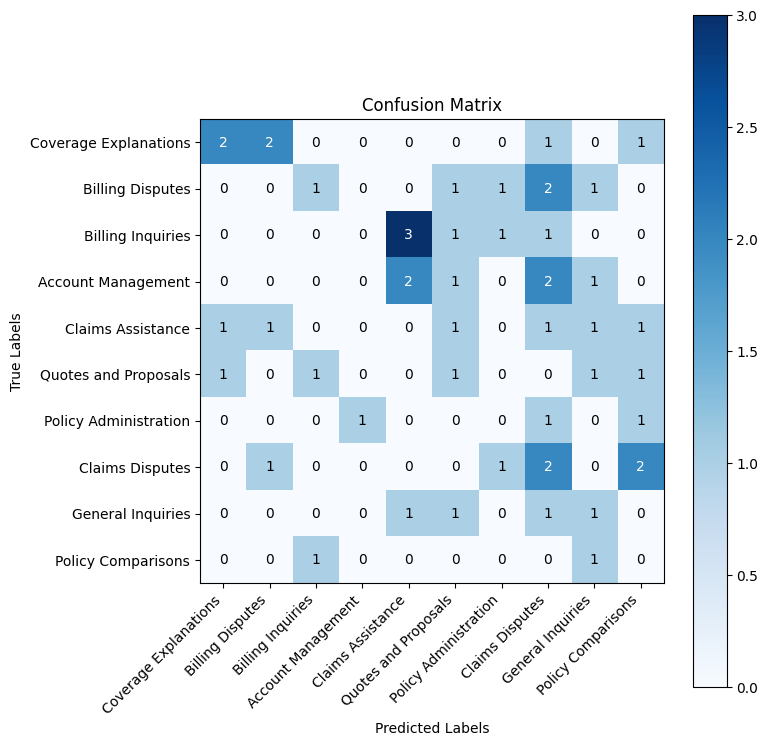

In [14]:
print("Evaluating the random classification method on the test set...")
evaluate(X_test, y_test, random_classifier)

### Simple classification test

Lets encode the categories into XML format

In [15]:
import textwrap

categories = textwrap.dedent("""<category> 
    <label>Billing Inquiries</label>
    <content> Questions about invoices, charges, fees, and premiums Requests for clarification on billing statements Inquiries about payment methods and due dates 
    </content> 
</category> 
<category> 
    <label>Policy Administration</label>
    <content> Requests for policy changes, updates, or cancellations Questions about policy renewals and reinstatements Inquiries about adding or removing coverage options 
    </content> 
</category> 
<category> 
    <label>Claims Assistance</label> 
    <content> Questions about the claims process and filing procedures Requests for help with submitting claim documentation Inquiries about claim status and payout timelines 
    </content> 
</category> 
<category> 
    <label>Coverage Explanations</label> 
    <content> Questions about what is covered under specific policy types Requests for clarification on coverage limits and exclusions Inquiries about deductibles and out-of-pocket expenses 
    </content> 
</category> 
<category> 
    <label>Quotes and Proposals</label> 
    <content> Requests for new policy quotes and price comparisons Questions about available discounts and bundling options Inquiries about switching from another insurer 
    </content> 
</category> 
<category> 
    <label>Account Management</label> 
    <content> Requests for login credentials or password resets Questions about online account features and functionality Inquiries about updating contact or personal information 
    </content> 
</category> 
<category> 
    <label>Billing Disputes</label> 
    <content> Complaints about unexpected or incorrect charges Requests for refunds or premium adjustments Inquiries about late fees or collection notices 
    </content> 
</category> 
<category> 
    <label>Claims Disputes</label> 
    <content> Complaints about denied or underpaid claims Requests for reconsideration of claim decisions Inquiries about appealing a claim outcome 
    </content> 
</category> 
<category> 
    <label>Policy Comparisons</label> 
    <content> Questions about the differences between policy options Requests for help deciding between coverage levels Inquiries about how policies compare to competitors' offerings 
    </content> 
</category> 
<category> 
    <label>General Inquiries</label> 
    <content> Questions about company contact information or hours of operation Requests for general information about products or services Inquiries that don't fit neatly into other categories 
    </content> 
</category>""")

Next we will construct a classify function that does the following things:

- Defines the prompt template (**simple prompt**)
- Inputs the variables in out prompt template
- Extracts a normalized response


Notice that we leverage the `role: assistant` message and the `stop_sequences` parameter to repeatably extract the results.

In [16]:
def simple_classify(X):
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Respond with just the label of the category between category tags.
    """).replace("{{categories}}", categories).replace("{{ticket}}", X)

    response = client.messages.create( 
        messages=[
            {"role":"user", "content": prompt}, 
            {"role":"assistant", "content": "<category>"}
        ],
        stop_sequences=["</category>"], 
        max_tokens=4096, 
        temperature=0.0,
        model=DEFAULT_MODEL
    )
    
    # Extract the result from the response
    result = response.content[0].text.strip()
    return result

In [18]:
print("Evaluating the simple classification method on the test set...")
evaluate(X_test, y_test, simple_classify)

Evaluating the simple classification method on the test set...


RateLimitError: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'This request would exceed your organization’s rate limit of 10,000 output tokens per minute. For details, refer to: https://docs.anthropic.com/en/api/rate-limits; see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}

Looks better now! Went from ~10% accuracy to ~70%

### Add RAG + K-shot prompting

We want to match a given query with similar examples form training data (and keep evaluating in test set).

We need to leverage a vector db for this.

**Vector DB class**

In [36]:
import os
import numpy as np
import voyageai
import pickle
import json

class VectorDB:
    def __init__(self, api_key=None):
        if api_key is None:
            api_key = os.getenv("VOYAGE_API_KEY")
        self.client = voyageai.Client(api_key=api_key)
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = "data/vector_db.pkl"

    def load_data(self, data):
        # Check if the vector database is already loaded
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        # Check if vector_db.pkl exists
        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        texts = [item["text"] for item in data]

        # Embed more than 128 documents with a for loop
        batch_size = 128
        result = [
            self.client.embed(
                texts[i : i + batch_size],
                model="voyage-2"
            ).embeddings
            for i in range(0, len(texts), batch_size)
        ]

        # Flatten the embeddings
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = [item for item in data]
        self.save_db()
        # Save the vector database to disk
        print("Vector database loaded and saved.")

    def search(self, query, k=5, similarity_threshold=0.75):
        
        query_embedding = None
        
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            query_embedding = self.client.embed([query], model="voyage-2").embeddings[0]
            self.query_cache[query] = query_embedding

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
        self.save_db()
        return top_examples
    
    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

Create database

In [ ]:
vectordb = VectorDB(api_key='')
vectordb.load_data(data["train"])

Loading vector database from disk.


Lets insert RAG to the prompt.
- Get top `k` matches
- Inyect to the prompt

In [39]:
def rag_classify(X):
    
    # Get top k matches
    rag = vectordb.search(X,5)
    rag_string = ""
    
    # Insert them in the prompt
    for example in rag:
        rag_string += textwrap.dedent(f"""
        <example>
            <query>
                "{example["metadata"]["text"]}"
            </query>
            <label>
                {example["metadata"]["label"]}
            </label>
        </example>
        """)
        
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Use the following examples to help you classify the query:
    <examples>
        {{examples}}
    </examples>

    Respond with just the label of the category between category tags.
    """).replace("{{categories}}", categories).replace("{{ticket}}", X).replace("{{examples}}", rag_string)
    
    response = client.messages.create( 
        messages=[
            {"role":"user", "content": prompt}, 
            {"role":"assistant", "content": "<category>"}
        ],
        stop_sequences=["</category>"], 
        max_tokens=4096, 
        temperature=0.0,
        model=DEFAULT_MODEL
    )
    
    # Extract the result from the response
    result = response.content[0].text.strip()
    return result

In [40]:
print("Evaluating the RAG method on the test set...")
evaluate(X_test, y_test, rag_classify)

Evaluating the RAG method on the test set...


RateLimitError: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'This request would exceed your organization’s rate limit of 10,000 output tokens per minute. For details, refer to: https://docs.anthropic.com/en/api/rate-limits; see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}

Goes up to 90% accuracy!

### RAG + Chain of thought prompt
Allow Claude to reflect on the results

In [41]:
def rag_chain_of_thought_classify(X):
    
    rag = vectordb.search(X,5)
    rag_string = ""
    
    for example in rag:
        rag_string += textwrap.dedent(f"""
        <example>
            <query>
                "{example["metadata"]["text"]}"
            </query>
            <label>
                {example["metadata"]["label"]}
            </label>
        </example>
        """)
    
    prompt = textwrap.dedent("""
    You will classify a customer support ticket into one of the following categories:
    <categories>
        {{categories}}
    </categories>

    Here is the customer support ticket:
    <ticket>
        {{ticket}}
    </ticket>

    Use the following examples to help you classify the query:
    <examples>
        {{examples}}
    </examples>

    First you will think step-by-step about the problem in scratchpad tags.
    You should consider all the information provided and create a concrete argument for your classification.
    
    Respond using this format:
    <response>
        <scratchpad>Your thoughts and analysis go here</scratchpad>
        <category>The category label you chose goes here</category>
    </response>
    """).replace("{{categories}}", categories).replace("{{ticket}}", X).replace("{{examples}}", rag_string)
    
    response = client.messages.create( 
        messages=[
            {"role":"user", "content": prompt}, 
            {"role":"assistant", "content": "<response><scratchpad>"}
        ],
        stop_sequences=["</category>"], 
        max_tokens=4096, 
        temperature=0.0,
        model=DEFAULT_MODEL
    )
    
    # Extract the result from the response
    result = response.content[0].text.split("<category>")[1].strip()
    return result

In [42]:
print("Evaluating the RAG method with Chain of Thought on the test set...")
evaluate(X_test, y_test, rag_chain_of_thought_classify)

Evaluating the RAG method with Chain of Thought on the test set...


RateLimitError: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'This request would exceed your organization’s rate limit of 10,000 output tokens per minute. For details, refer to: https://docs.anthropic.com/en/api/rate-limits; see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}

Goes to 94% accuracy!

### Evaluation

Compare different model paramters and prompts.

Use **promptfoo** as here: https://github.com/anthropics/anthropic-cookbook/tree/main/skills/classification/evaluation